In [1]:
!git clone https://github.com/beckhamtoh/char-llm-assignment.git
%cd char-llm-assignment

Cloning into 'char-llm-assignment'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 103 (delta 44), reused 72 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (103/103), 30.55 MiB | 20.71 MiB/s, done.
Resolving deltas: 100% (44/44), done.
/kaggle/working/char-llm-assignment


In [2]:
# Enable autoreload of local Python modules (e.g., models)
# %load_ext autoreload
# %autoreload 2

# manual reload for local modules
import importlib

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import jax
import jax.numpy as jnp
import optax
import time
import matplotlib.pyplot as plt

# local imports
import models.models as models
import util.generation as generation


In [4]:
# initialize the jax random key
key = jax.random.key(0)

INFO:2025-10-31 12:40:19,549:jax._src.xla_bridge:924: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-10-31 12:40:19,560:jax._src.xla_bridge:924: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


# Load data

In [5]:
# load the ./data/text8_train.txt and ./data/text8_test.txt files
with open("./data/text8_train.txt", "r") as f:
    train_text = f.read()
with open("./data/text8_test.txt", "r") as f:
    test_text = f.read()

# print the length of the training text and test text
print(f"Length of training text: {len(train_text):_} characters")
print(f"Length of test text: {len(test_text):_} characters")

Length of training text: 90_000_000 characters
Length of test text: 5_000_000 characters


In [6]:
# Build vocabulary (lowercase + space + a few punctuations)
char_set = list("abcdefghijklmnopqrstuvwxyz ")
char_to_int = {ch:i for i,ch in enumerate(char_set)}
int_to_char = {i:ch for ch,i in char_to_int.items()}

def encode(s):
    """Encode string to array of integers"""
    ids = [char_to_int[c] for c in s]
    return np.array(ids, dtype=np.uint8)  # use np.uint8 to save space

In [7]:
# encode the text
train_text_int = encode(train_text)
test_text_int = encode(test_text)

In [8]:
# sanity check: display a few random characters from the training text
T = 128
for _ in range(5):
    # choose random position in text
    N = np.random.randint(low=0, high=len(train_text)-T)
    print(train_text[N:N+T])
    print()

eynolds had hoped to continue in coalition with the progressive democrats however following the beef tribunal the pds withdrew f

nned from nine zero zero bc to three zero zero bc inca holding their capital at the great city of cusco the inca civilization do

ine four most contemporary accounts therefore will contain inaccurate accounts of ruth s age ruth continued to use the one eight

ly observing the fiction that his powers came from these offices granted to him rather than from his own person or the many legi

ppearance and some subset of their capabilities industrial robots have become commonplace in mass production but general purpose



# Create a basic Transformer model

In [9]:
def create_train_state(rng, vocab_size=27, d_model=64, n_layers=6, n_heads=8, max_len=128, pos_encoding_type='learned'):
    # create a basic Transformer model with specified positional encoding
    model = models.DecoderOnlyTransformer(
        vocab_size, 
        d_model, 
        n_layers, 
        n_heads, 
        max_len,
        pos_encoding_type=pos_encoding_type  
    )
    # create a dummy input for initialization
    dummy = jnp.zeros((1, min(16, max_len)), dtype=jnp.int32)
    # pass the dummy input to the model to initialize the parameters
    params = model.init({"params": rng}, dummy)["params"]
    return model, params

In [10]:
# vocab size
vocab_size= len(char_set)

# internal model dimensions
d_model=256

# number of attention heads
n_heads=8

# number of Transformer layers
n_layers=2

# maximum sequence length
max_len=128

# learning rate for the optimizer
learning_rate = 0.001

# Loss function

In [11]:
@jax.jit
def loss_and_metrics(logits, targets):
    """Compute cross-entropy loss and accuracy.

    Assumes `targets` contains only valid integer class ids in [0, V-1] (no -1 ignore tokens).

    Args:
      logits: (B, T, V) float array of unnormalized scores.
      targets: (B, T) integer array with ground-truth class ids.

    Returns:
      loss: scalar average cross-entropy over all positions.
      metrics: dict with keys "loss" and "acc" (both scalars).
    """
    # Flatten batch/time dims so optax works on shape (N, V) and (N,)
    vocab = logits.shape[-1]
    flat_logits = logits.reshape(-1, vocab)
    flat_targets = targets.reshape(-1)

    # Per-position cross-entropy, then mean over all positions
    per_pos = optax.softmax_cross_entropy_with_integer_labels(flat_logits, flat_targets)
    loss = per_pos.mean()

    # prediction over all positions
    preds = jnp.argmax(logits, axis=-1)  # (B, T)

    # compute accuracy over only the last position
    is_match = preds == targets

    # Accuracy over all positions
    acc_all = jnp.mean(is_match.astype(jnp.float32))

    # Accuracy over only last position
    acc_last = jnp.mean(is_match.astype(jnp.float32)[:,-1])

    return loss, {"loss": loss, "acc": acc_all, "acc_last": acc_last}

# Optimization step:

In [12]:
# Optimization step:
# create an update function
def train_step(model, params, opt_state, x, y, tx):
    """Single optimization step using optax optimizer.

    Args:
      model: The model to train.
      params: pytree of model parameters.
      opt_state: optax optimizer state corresponding to `params`.
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
      tx: optax.GradientTransformation (already initialized).

    Returns:
      new_params: updated parameters after one gradient step.
      new_opt_state: updated optimizer state.
      metrics: dict of scalar metrics (loss, acc).
    """
    def loss_fn(params):
        logits = model.apply({"params": params}, x)
        loss, metrics = loss_and_metrics(logits, y)
        return loss, metrics

    # compute gradients (loss is scalar, metrics is auxiliary)
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # optax update: compute parameter updates and new optimizer state
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics

# jit: last argument should be static because it is an object
train_step = jax.jit(train_step, static_argnames=("model", "tx"))

# Batch creation:

In [13]:
# create a batch from the training data
def get_batch(text_int, B, T):
    """Create a random batch of data from text_int.

    Args:
      text_int: 1D array of token ids.
      B: batch size (number of sequences).
      T: sequence length (number of tokens per sequence).

    Returns:
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
    """
    # choose random starting indices for each sequence in the batch
    ix = np.random.randint(0, len(text_int) - T, size=B)
    # inputs are text from i to i+T
    x = np.stack([text_int[i:i+T] for i in ix])
    # targets are text from i+1 to i+T+1
    y = np.stack([text_int[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)

In [14]:
# Helper function for counting parameters
def count_params(params):
    return sum(x.size for x in jax.tree_util.tree_leaves(params))

# Position Encoding Test

In [15]:
def train_model_with_config(pos_encoding_type, niter=5000, B=128, T=32, 
                           d_model=256, n_layers=2, n_heads=8, 
                           max_len=128, learning_rate=0.001,
                           eval_interval=100, seed=42):
    """
    Train a model with specified positional encoding type and return results.
    
    Args:
        pos_encoding_type: 'learned', 'sinusoidal', 'rotary', or 'none'
        niter: Number of training iterations
        B: Batch size
        T: Sequence length
        d_model: Hidden dimension
        n_layers: Number of transformer layers
        n_heads: Number of attention heads
        max_len: Maximum sequence length
        learning_rate: Learning rate for optimizer
        eval_interval: How often to evaluate on test set
        seed: Random seed for reproducibility
        
    Returns:
        Dictionary with training history and final model/params
    """
    print(f"\n{'='*70}")
    print(f"Training with {pos_encoding_type.upper()} positional encoding")
    print(f"{'='*70}")
    
    # Initialize random key
    local_key = jax.random.PRNGKey(seed)
    
    # Create model
    model, params = create_train_state(
        local_key, 
        vocab_size=vocab_size, 
        d_model=d_model, 
        n_layers=n_layers, 
        n_heads=n_heads, 
        max_len=max_len,
        pos_encoding_type=pos_encoding_type
    )
    
    # Print model info
    n_params = count_params(params)
    print(f"Number of parameters: {n_params:_}")
    
    # Create optimizer
    tx = optax.adam(learning_rate=learning_rate)
    opt_state = tx.init(params)
    
    # Training history
    history = {
        'iteration': [],
        'time': [],
        'train_loss': [],
        'train_acc': [],
        'train_acc_last': [],
        'test_loss': [],
        'test_acc': [],
        'test_acc_last': [],
    }
    
    time_start = time.time()
    
    # Training loop
    for it in range(niter):
        # Get batch
        batch = get_batch(train_text_int, B, T)
        input_tokens, target_tokens = batch[0], batch[1]

        # Training step
        params, opt_state, metrics = train_step(
            model, params, opt_state, input_tokens, target_tokens, tx
        )
        
        # Evaluate at intervals
        if it % eval_interval == 0 or it == niter - 1:
            time_elapsed = time.time() - time_start
            
            # Compute test metrics
            B_test, T_test = 1024, 32
            test_batch = get_batch(test_text_int, B_test, T_test)
            test_input, test_target = test_batch[0], test_batch[1]
            test_logits = model.apply({"params": params}, test_input)
            test_loss, test_metrics = loss_and_metrics(test_logits, test_target)
            
            # Store history
            history['iteration'].append(it)
            history['time'].append(time_elapsed)
            history['train_loss'].append(float(metrics['loss']))
            history['train_acc'].append(float(metrics['acc']))
            history['train_acc_last'].append(float(metrics['acc_last']))
            history['test_loss'].append(float(test_loss))
            history['test_acc'].append(float(test_metrics['acc']))
            history['test_acc_last'].append(float(test_metrics['acc_last']))
            
            # Print progress
            print(f"Iter {it:5d}/{niter} | Time: {time_elapsed:6.1f}s | "
                  f"Train Loss: {metrics['loss']:.4f} | Test Loss: {test_loss:.4f} | "
                  f"Train Acc: {100*metrics['acc']:.1f}% | Test Acc: {100*test_metrics['acc']:.1f}%")
    
    print(f"\nTraining completed in {time.time() - time_start:.1f} seconds")
    print(f"Final test accuracy: {100*history['test_acc'][-1]:.2f}%")
    print(f"Final test accuracy (last char): {100*history['test_acc_last'][-1]:.2f}%")
    
    return {
        'model': model,
        'params': params,
        'history': history,
        'pos_encoding_type': pos_encoding_type,
        'config': {
            'niter': niter,
            'B': B,
            'T': T,
            'd_model': d_model,
            'n_layers': n_layers,
            'n_heads': n_heads,
            'max_len': max_len,
            'learning_rate': learning_rate,
            'n_params': n_params,
        }
    }


# Parameters

In [16]:
NITER = 5000
BATCH_SIZE = 128
SEQ_LENGTH = 32
EVAL_INTERVAL = 100

# Test

In [17]:
# Positional encoding types to test
encoding_types = ['rotary', 'learned', 'sinusoidal', 'none']

# Store results
results = {}

# Run experiments
for encoding_type in encoding_types:
    results[encoding_type] = train_model_with_config(
        pos_encoding_type=encoding_type,
        niter=NITER,
        B=BATCH_SIZE,
        T=SEQ_LENGTH,
        d_model=d_model,  # Use the values defined earlier
        n_layers=n_layers,
        n_heads=n_heads,
        max_len=max_len,
        learning_rate=learning_rate,
        eval_interval=EVAL_INTERVAL,
        seed=42
    )

print("\n" + "="*70)
print("ALL EXPERIMENTS COMPLETED")
print("="*70)


Training with ROTARY positional encoding
Number of parameters: 1_591_808
Iter     0/5000 | Time:    4.0s | Train Loss: 3.5589 | Test Loss: 3.7927 | Train Acc: 4.8% | Test Acc: 17.3%
Iter   100/5000 | Time:    8.6s | Train Loss: 2.1073 | Test Loss: 2.1323 | Train Acc: 35.1% | Test Acc: 35.2%
Iter   200/5000 | Time:   10.1s | Train Loss: 1.9494 | Test Loss: 1.9429 | Train Acc: 41.0% | Test Acc: 40.8%
Iter   300/5000 | Time:   11.7s | Train Loss: 1.8446 | Test Loss: 1.8383 | Train Acc: 44.4% | Test Acc: 43.8%
Iter   400/5000 | Time:   13.2s | Train Loss: 1.7122 | Test Loss: 1.7677 | Train Acc: 48.1% | Test Acc: 46.2%
Iter   500/5000 | Time:   14.7s | Train Loss: 1.6563 | Test Loss: 1.7261 | Train Acc: 49.2% | Test Acc: 47.6%
Iter   600/5000 | Time:   16.3s | Train Loss: 1.7292 | Test Loss: 1.6762 | Train Acc: 47.4% | Test Acc: 48.8%
Iter   700/5000 | Time:   17.8s | Train Loss: 1.6469 | Test Loss: 1.6390 | Train Acc: 49.8% | Test Acc: 50.0%
Iter   800/5000 | Time:   19.3s | Train Loss: 1

# Plotting & Analysis

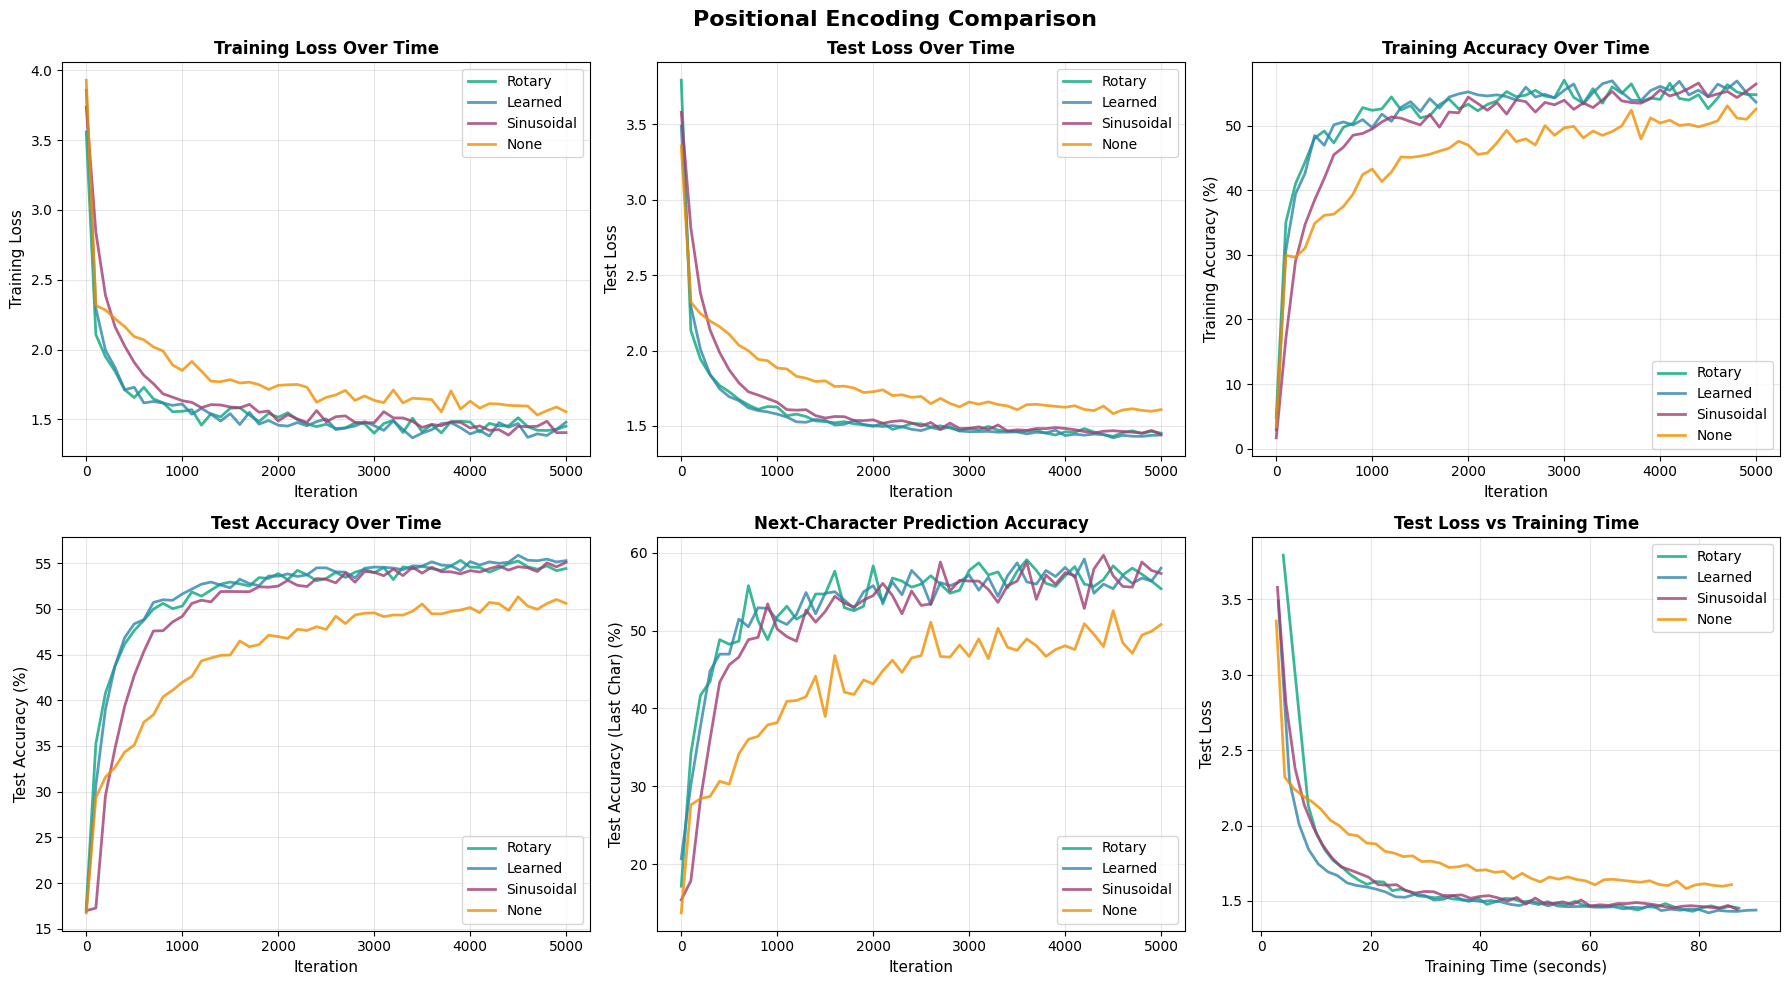


Figure saved as 'positional_encoding_comparison.png'


In [18]:
# Create a comprehensive figure with multiple subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Positional Encoding Comparison', fontsize=16, fontweight='bold')

# Define colors for each encoding type
colors = {
    'learned': '#2E86AB',
    'sinusoidal': '#A23B72',
    'none': '#F18F01',
    'rotary': '#06A77D'
}

# 1. Training Loss vs Iterations
ax = axes[0, 0]
for enc_type, result in results.items():
    history = result['history']
    ax.plot(history['iteration'], history['train_loss'], 
            label=enc_type.capitalize(), color=colors[enc_type], 
            linewidth=2, alpha=0.8)
ax.set_xlabel('Iteration', fontsize=11)
ax.set_ylabel('Training Loss', fontsize=11)
ax.set_title('Training Loss Over Time', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Test Loss vs Iterations
ax = axes[0, 1]
for enc_type, result in results.items():
    history = result['history']
    ax.plot(history['iteration'], history['test_loss'], 
            label=enc_type.capitalize(), color=colors[enc_type], 
            linewidth=2, alpha=0.8)
ax.set_xlabel('Iteration', fontsize=11)
ax.set_ylabel('Test Loss', fontsize=11)
ax.set_title('Test Loss Over Time', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Training Accuracy vs Iterations
ax = axes[0, 2]
for enc_type, result in results.items():
    history = result['history']
    acc_percent = [a * 100 for a in history['train_acc']]
    ax.plot(history['iteration'], acc_percent, 
            label=enc_type.capitalize(), color=colors[enc_type], 
            linewidth=2, alpha=0.8)
ax.set_xlabel('Iteration', fontsize=11)
ax.set_ylabel('Training Accuracy (%)', fontsize=11)
ax.set_title('Training Accuracy Over Time', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Test Accuracy vs Iterations
ax = axes[1, 0]
for enc_type, result in results.items():
    history = result['history']
    acc_percent = [a * 100 for a in history['test_acc']]
    ax.plot(history['iteration'], acc_percent, 
            label=enc_type.capitalize(), color=colors[enc_type], 
            linewidth=2, alpha=0.8)
ax.set_xlabel('Iteration', fontsize=11)
ax.set_ylabel('Test Accuracy (%)', fontsize=11)
ax.set_title('Test Accuracy Over Time', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Last Character Accuracy (Test) - Most Important Metric
ax = axes[1, 1]
for enc_type, result in results.items():
    history = result['history']
    acc_percent = [a * 100 for a in history['test_acc_last']]
    ax.plot(history['iteration'], acc_percent, 
            label=enc_type.capitalize(), color=colors[enc_type], 
            linewidth=2, alpha=0.8)
ax.set_xlabel('Iteration', fontsize=11)
ax.set_ylabel('Test Accuracy (Last Char) (%)', fontsize=11)
ax.set_title('Next-Character Prediction Accuracy', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. Training Time Comparison
ax = axes[1, 2]
for enc_type, result in results.items():
    history = result['history']
    ax.plot(history['time'], history['test_loss'], 
            label=enc_type.capitalize(), color=colors[enc_type], 
            linewidth=2, alpha=0.8)
ax.set_xlabel('Training Time (seconds)', fontsize=11)
ax.set_ylabel('Test Loss', fontsize=11)
ax.set_title('Test Loss vs Training Time', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('positional_encoding_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFigure saved as 'positional_encoding_comparison.png'")

# Summary Table

In [19]:
print("\n" + "="*90)
print("FINAL RESULTS SUMMARY")
print("="*90)
print(f"{'Encoding Type':<20} {'Parameters':<15} {'Train Loss':<12} {'Test Loss':<12} "
      f"{'Test Acc':<12} {'Last Char Acc':<15} {'Time (s)':<10}")
print("-"*90)

for enc_type, result in results.items():
    history = result['history']
    config = result['config']
    
    final_train_loss = history['train_loss'][-1]
    final_test_loss = history['test_loss'][-1]
    final_test_acc = history['test_acc'][-1] * 100
    final_test_acc_last = history['test_acc_last'][-1] * 100
    final_time = history['time'][-1]
    n_params = config['n_params']
    
    print(f"{enc_type.capitalize():<20} {n_params:<15,} {final_train_loss:<12.4f} "
          f"{final_test_loss:<12.4f} {final_test_acc:<12.2f}% {final_test_acc_last:<15.2f}% "
          f"{final_time:<10.1f}")

print("="*90)

# Find best performing model
best_enc_type = max(results.keys(), 
                    key=lambda k: results[k]['history']['test_acc_last'][-1])
best_acc = results[best_enc_type]['history']['test_acc_last'][-1] * 100

print(f"\n🏆 Best performing encoding: {best_enc_type.upper()} "
      f"with {best_acc:.2f}% next-character prediction accuracy")


FINAL RESULTS SUMMARY
Encoding Type        Parameters      Train Loss   Test Loss    Test Acc     Last Char Acc   Time (s)  
------------------------------------------------------------------------------------------
Rotary               1,591,808       1.4512       1.4524       54.42       % 55.37          % 87.3      
Learned              1,624,576       1.4801       1.4395       55.29       % 58.01          % 90.4      
Sinusoidal           1,591,808       1.4056       1.4435       55.10       % 57.32          % 87.0      
None                 1,591,808       1.5545       1.6083       50.60       % 50.78          % 85.9      

🏆 Best performing encoding: LEARNED with 58.01% next-character prediction accuracy


# Individual plots

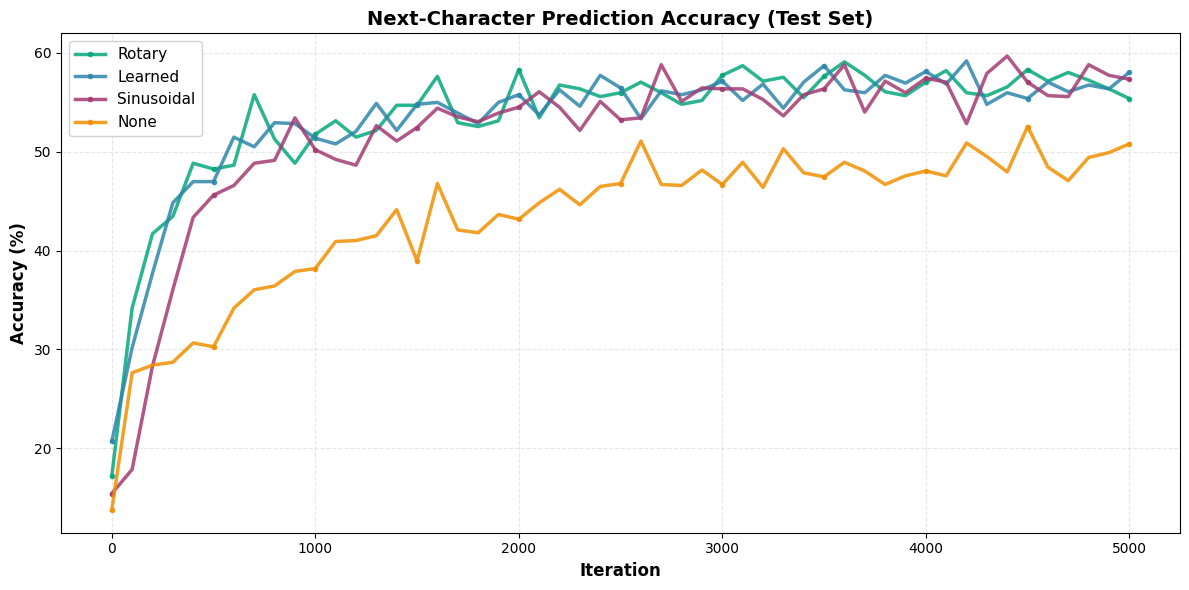

Saved: detailed_test_acc_last.png


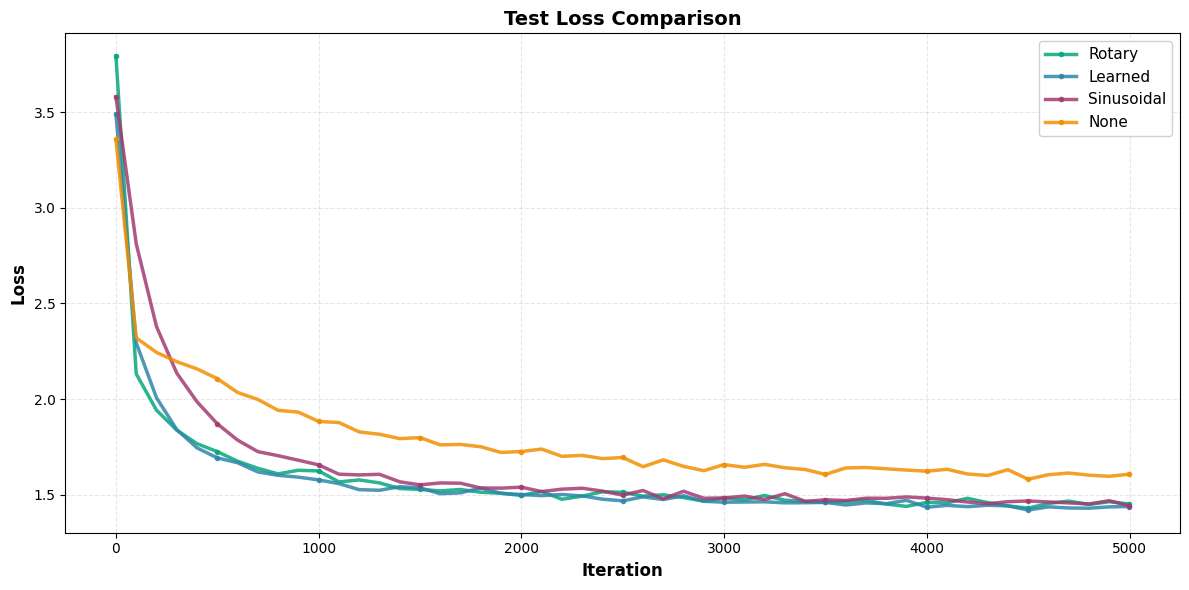

Saved: detailed_test_loss.png


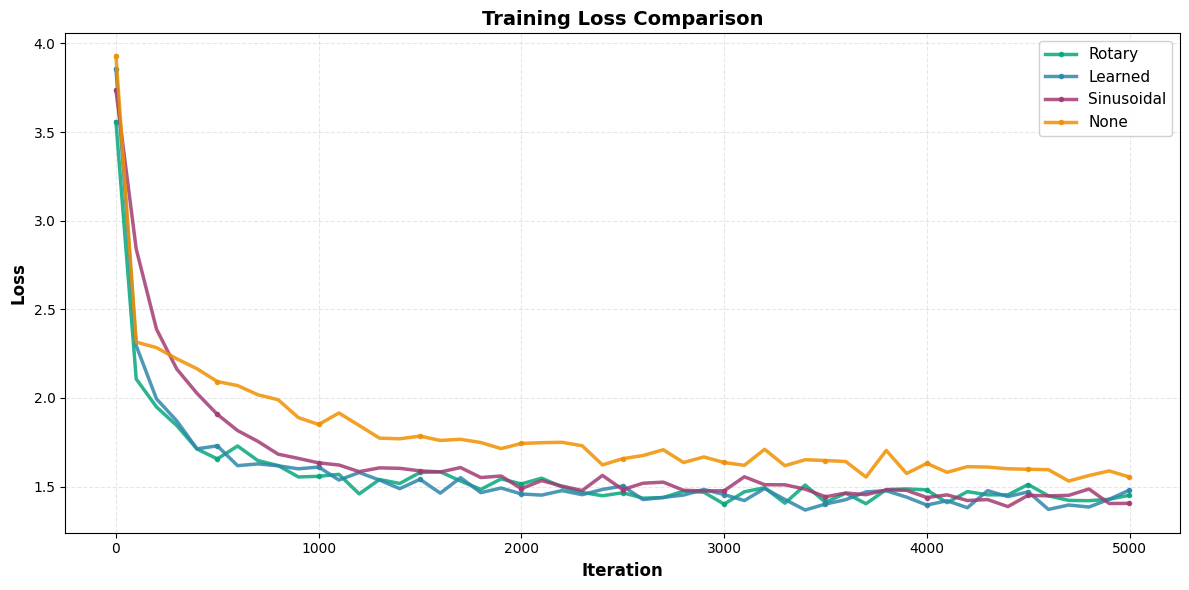

Saved: detailed_train_loss.png


In [20]:
def plot_detailed_comparison(results, metric='test_acc_last', title='Test Accuracy (Last Character)'):
    """Create a detailed plot for a specific metric."""
    plt.figure(figsize=(12, 6))
    
    for enc_type, result in results.items():
        history = result['history']
        
        if 'acc' in metric:
            values = [v * 100 for v in history[metric]]
            ylabel = 'Accuracy (%)'
        else:
            values = history[metric]
            ylabel = 'Loss'
        
        plt.plot(history['iteration'], values, 
                label=f"{enc_type.capitalize()}", 
                color=colors[enc_type],
                linewidth=2.5, alpha=0.85, marker='o', markersize=3, markevery=5)
    
    plt.xlabel('Iteration', fontsize=12, fontweight='bold')
    plt.ylabel(ylabel, fontsize=12, fontweight='bold')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(fontsize=11, framealpha=0.9)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    
    filename = f"detailed_{metric}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {filename}")

# Create detailed plots for key metrics
plot_detailed_comparison(results, 'test_acc_last', 
                        'Next-Character Prediction Accuracy (Test Set)')
plot_detailed_comparison(results, 'test_loss', 
                        'Test Loss Comparison')
plot_detailed_comparison(results, 'train_loss', 
                        'Training Loss Comparison')

# Generate Sample Text

In [21]:
print("\n" + "="*70)
print("TEXT GENERATION COMPARISON")
print("="*70)

prompts = [
    "the quick brown",
    "hello world",
    "once upon a time"
]

for prompt in prompts:
    print(f"\n{'='*70}")
    print(f"Prompt: '{prompt}'")
    print('='*70)
    
    for enc_type, result in results.items():
        model = result['model']
        params = result['params']
        
        # Encode prompt
        prompt_int = jnp.array(
            [[char_to_int.get(c, 0) for c in prompt.lower()[:64]]], 
            dtype=jnp.int32
        )
        
        # Generate
        rng = jax.random.PRNGKey(42)
        gen_len = 100
        out_ids = generation.generate_tokens(
            model, params, rng, prompt_int, gen_len, 
            block_size=max_len, temperature=0.7, sample=True
        )
        
        # Decode
        generated_text = ''.join(
            int_to_char.get(int(x), '?') for x in list(out_ids[0])
        )
        full_text = prompt + generated_text
        
        print(f"\n{enc_type.upper()}:")
        print(f"{full_text[:150]}...")  # Print first 150 chars


TEXT GENERATION COMPARISON

Prompt: 'the quick brown'

ROTARY:
the quick brown il ndclidc bsrltnt h kint pnrtl niralmann hndarinestildinorchn t cctreis thcyon unenoli th e r b in...

LEARNED:
the quick brown ie s caido as as wah ain a t tl ain ps as h fllp es ch c s c a t camadard mu ov uremodinte itatag p...

SINUSOIDAL:
the quick brown nl nlc n t rerl l  h  tutat r l nigtunl nnh  lrp ls clr  ruc n t c n tar t ur v ubnnonnnt  ennan  a...

NONE:
the quick brown il stin wo ws lt w h kidy on al nirt mannnd fted es chou ouch borcha cas w de p unevon the ior be p...

Prompt: 'hello world'

ROTARY:
hello world il ndclimo ble tht h nityntn to niit manndnn crptistino thect st cctees dimolontune ong th emalen p...

LEARNED:
hello world ie ad aido ae a a sh ain a t tl aiaa madadh fllp es ch c s can t cam cad wad ov ulles ines e wing p...

SINUSOIDAL:
hello world nl nlc n t rerl l  h  t    n tl nig  nl nnh  lrp ls clr  ruc n t c m c r  mu  t u  morinta nor ag a...

NONE:
hello world il stinido 